#### 텐서플로 설치

In [1]:
!pip install tensorflow

In [2]:
#GPU 용 텐서플로 설치
!pip install tensorflow-gpu

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Anaconda3\\envs\\dsfs\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [3]:
#텐서플로 버전 확인 
import tensorflow as tf
print(tf.__version__)

2.5.0


### 텐서플로 1.x 방식의 저수준 API

In [5]:
##그래프 생성
g = tf.Graph()

with g.as_default():
    x = tf.compat.v1.placeholder(dtype=tf.float32,
                                shape = (None), name = 'x')#1차원 데이터셋 x
    w = tf.Variable(2.0, name = 'weight')#가중치 w
    b = tf.Variable(0.7, name = 'bias')#절편 b
    
    z = w*x+b#최종입력 계산 z
    init = tf.compat.v1.global_variables_initializer()

##세션을 만들고 그래프 g를 전달함
with tf.compat.v1.Session(graph=g) as sess:#세션을 만듦, 그래프 g를 전달
    ##w와 b를 초기화
    sess.run(init)
    
    #z를 평가
    for t in [1.0,0.6,-1.8]:
        print("x=%4.1f --> z=%4.1f"%(t,sess.run(z,feed_dict = {x:t})))#z평가

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [6]:
#원소 하나씩 차례대로 모델에 주입
with tf.compat.v1.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict = {x:[1.,2.,3.]}))

[2.7 4.7 6.7]


In [7]:
#텐서 z 출력
print(z)

Tensor("add:0", dtype=float32)


### 텐서플로 2.x 방식

In [8]:
w = tf.Variable(2.0, name = 'weight')#가중치 w=2.0
b = tf.Variable(0.7, name = 'bias')#절편 b= 0.7

In [9]:
#z를 평가
for x in [1.0,0.6,-1.8]:
    z = w*x + b
    print('x = %4.1f --> z= %4.1f'%(x,z))

x =  1.0 --> z=  2.7
x =  0.6 --> z=  1.9
x = -1.8 --> z= -2.9


In [10]:
print(z)#마지막 실행 결과인 -2.9 출력

tf.Tensor(-2.8999999, shape=(), dtype=float32)


In [11]:
z = w*[1.,2.,3.]+b#리스트 데이터 한 번에 계산 가능
print(z.numpy())#넘파이 배열로 출력

[2.7 4.7 6.7]


### 배열 구조 다루기

In [18]:
import tensorflow as tf
import numpy as np

x_array = np.arange(18).reshape(3,2,3)
x2 = tf.reshape(x_array, shape = (-1, 6))#턴서 크기를 바꿈 tf.reshape()

#각 열의 합을 계산
xsum = tf.reduce_sum(x2,axis = 0)#열 column의 합(axis = 0)

#각 열의 평균을 계산
xmean = tf.reduce_mean(x2, axis = 0)#열 column의 평균(axis = 0)

print("입력 크기: ", x_array.shape)
print("\n크기가 변경된 입력:\n",x2.numpy())
print("\n열의 합:\n",xsum.numpy())
print("\n열의 평균:\n",xmean.numpy())

입력 크기:  (3, 2, 3)

크기가 변경된 입력:
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]

열의 합:
 [18 21 24 27 30 33]

열의 평균:
 [ 6  7  8  9 10 11]


In [19]:
import tensorflow as tf
import numpy as np

x_array = np.arange(18).reshape(3,2,3)
x2 = tf.reshape(x_array, shape = (-1, 6))#턴서 크기를 바꿈 tf.reshape()

#각 열의 합을 계산
ysum = tf.reduce_sum(x2,axis = 1)#열 column의 합(axis = 0)

#각 열의 평균을 계산
ymean = tf.reduce_mean(x2, axis = 1)#열 column의 평균(axis = 0)

print("입력 크기: ", x_array.shape)
print("\n크기가 변경된 입력:\n",x2.numpy())
print("\n행의 합:\n",ysum.numpy())
print("\n행의 평균:\n",ymean.numpy())

입력 크기:  (3, 2, 3)

크기가 변경된 입력:
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]

행의 합:
 [15 51 87]

행의 평균:
 [ 2  8 14]


### 텐서플로 저수준 API로 간단한 모델 개발

In [21]:
X_train = np.arange(10).reshape((10,1))#10개의 훈련 샘플
y_train = np.array([1.0,1.3,3.1,
                   2.0,5.0,6.3,
                   6.6,7.4,8.0,
                   9.0])

In [22]:
class TfLinreg(object):#선형 회귀 모델
    
    def __init__(self, learning_rate = 0.01):
        #가중치와 절편 정의
        self.w = tf.Variable(tf.zeros(shape=(1)))
        self.b = tf.Variable(tf.zeros(shape = (1)))
        
        #경사하강법 옵티마이저 설정
        self.optimizer = tf.keras.optimizers.SGD(lr = learning_rate)
    
    def fit(self,X,y,num_epochs = 10):#훈련
        ##비용함수의 값을 저장하기 위한 리스트 정의
        training_costs = []#비용 함수 값 저장 리스트
        for step in range(num_epochs):#에포크마다
            ##자동 미분을 위해 연산 과정 기록
            with tf.GradientTape() as tape:
                z_net = self.w *X + self.b
                z_net = tf.reshape(z_net, [-1])
                sqr_errors = tf.square(y-z_net)#오차행렬
                mean_cost = tf.reduce_mean(sqr_errors)#평균 제곱 오차 MSE
            
            #비용함수에 대한 가중치의 그래디언트를 계산
            grads = tape.gradient(mean_cost, [self.w, self.b])#(미분대상, 그래디언트를 구하려는 변수 리스트)
            
            #옵티마이저에 그래디언트를 반영
            self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))#(그래디언트, 변수 튜플)
            
            #비용함수의 값을 저장
            training_costs.append(mean_cost.numpy())
                
        return training_costs#비용함수 반환

In [29]:
lrmodel = TfLinreg()#인스턴스 생성

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [30]:
training_costs = 
lrmodel.fit(X_train,y_train)#모델 훈련

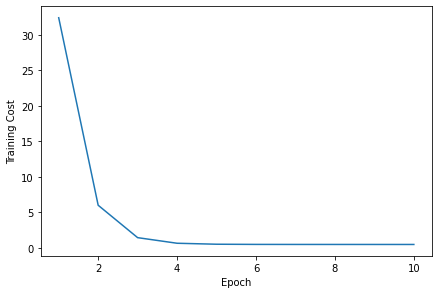

In [25]:
#열번의 에포크동안 계산된 훈련 비용 시각화
import matplotlib.pyplot as plt
plt.plot(range(1,len(training_costs)+1),training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()#수렴함

예측 메서드 추가

In [37]:
class TfLinreg(object):#선형 회귀 모델
    
    def __init__(self, learning_rate = 0.01):
        #가중치와 절편 정의
        self.w = tf.Variable(tf.zeros(shape=(1)))
        self.b = tf.Variable(tf.zeros(shape = (1)))
        
        #경사하강법 옵티마이저 설정
        self.optimizer = tf.keras.optimizers.SGD(lr = learning_rate)
    
    def fit(self,X,y,num_epochs = 10):#훈련
        ##비용함수의 값을 저장하기 위한 리스트 정의
        training_costs = []#비용 함수 값 저장 리스트
        for step in range(num_epochs):#에포크마다
            ##자동 미분을 위해 연산 과정 기록
            with tf.GradientTape() as tape:
                z_net = self.w *X + self.b
                z_net = tf.reshape(z_net, [-1])
                sqr_errors = tf.square(y-z_net)#오차행렬
                mean_cost = tf.reduce_mean(sqr_errors)#평균 제곱 오차 MSE
            
            #비용함수에 대한 가중치의 그래디언트를 계산
            grads = tape.gradient(mean_cost, [self.w, self.b])#(미분대상, 그래디언트를 구하려는 변수 리스트)
            
            #옵티마이저에 그래디언트를 반영
            self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))#(그래디언트, 변수 튜플)
            
            #비용함수의 값을 저장
            training_costs.append(mean_cost.numpy())
                
        return training_costs#비용함수 반환
    
    def predict(self,X):#예측 매서드 추가
        return self.w*X + self.b

In [38]:
lrmodel = TfLinreg()#인스턴스 생성

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [39]:
training_costs = lrmodel.fit(X_train,y_train)#모델 훈련

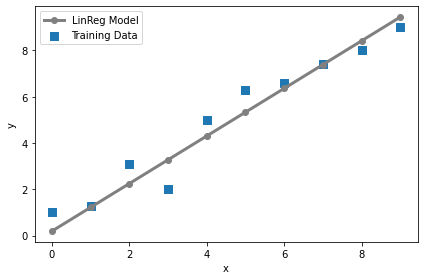

In [40]:
#훈련데아터와 학습된 선형 회귀 곡선 시각화
plt.scatter(X_train, y_train,
           marker ='s',
           s=50,
           label = 'Training Data')

plt.plot(range(X_train.shape[0]),
        lrmodel.predict(X_train),
        color = 'gray',marker='o',
        markersize=6, linewidth=3,
        label = 'LinReg Model')#선형회귀곡선

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

훈련 데이터셋과 테스트 데이터셋 로드

In [41]:
#서버 액세스 안되서 그냥 불러옴
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [42]:
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)

In [44]:
print("행: %d, 열: %d"%(X_train.shape[0],X_train.shape[1]))
print("행: %d, 열: %d"%(X_test.shape[0],X_test.shape[1]))

행: 60000, 열: 784
행: 10000, 열: 784


In [46]:
#평균을 0으로 만들고 표준편차로 나눔(정규화)
mean_vals = np.mean(X_train, axis = 0)
std_val = np.std(X_train)

X_train_centered = (X_train-mean_vals)/std_val
X_test_centered = (X_test-mean_vals)/std_val

del X_train,X_test

print(X_train_centered.shape,y_train.shape)
print(X_test_centered.shape,y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [47]:
#넘파이 난수 초깃값 생성
np.random.seed(123)

In [48]:
#클래스 레이블 원-핫 인코딩
y_train_onehot  = tf.keras.utils.to_categorical(y_train)
print("처음 3개 레이블:", y_train[:3])
print("\n 처음 3개 레이블 (원-핫):\n",y_train_onehot[:3])

처음 3개 레이블: [5 0 4]

 처음 3개 레이블 (원-핫):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


###  tf.keras API를 이용한 신경망 구성

In [50]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Dense(
        units = 50,
        input_dim = X_train_centered.shape[1],#input_dim이 훈련세트에 있는 특성(열) 개수와 일치해야 함
        kernel_initializer = 'glorot_uniform',#새로은 가중치 행렬 초기화 알고리즘(심층 신경망을 안정적으로 초기화하는 방법)
        bias_initializer = 'zeros',
        activation='tanh'#하이퍼볼릭 탄젠트
    )
)

model.add(
    tf.keras.layers.Dense(
        units = 50,#units == input_dim
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'#하이퍼볼릭 탄젠트
    )
)

model.add(
    tf.keras.layers.Dense(
        units = y_train_onehot.shape[1],
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer='zeros',
        activation = 'softmax'
    )
)

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


#### 피드포워드 신경망 훈련

In [53]:
sgd_optimizer = tf.keras.optimizers.SGD(lr=0.001, decay = 1e-7, momentum = .9)#경사하강법 옵티마이저

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [54]:
#모델 컴파일
model.compile(optimizer=sgd_optimizer,
             loss = 'categorical_crossentropy')#범주형 크로스엔트로피 손실 함수

In [55]:
#훈련
history = model.fit(X_train_centered, y_train_onehot,
                   batch_size=64, epochs=50,
                   verbose = 1,#훈련동안 비용함수 따라가기
                    validation_split=0.1)#훈련 데이터의 10%를 검증 데이터로 할당

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 0.7227 - val_loss: 0.3627
Epoch 2/50
844/844 [==============================] - 2s 3ms/step - loss: 0.3707 - val_loss: 0.2756
Epoch 3/50
844/844 [==============================] - 2s 2ms/step - loss: 0.3052 - val_loss: 0.2360
Epoch 4/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2688 - val_loss: 0.2119
Epoch 5/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2428 - val_loss: 0.1953
Epoch 6/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2230 - val_loss: 0.1823
Epoch 7/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2065 - val_loss: 0.1724
Epoch 8/50
844/844 [==============================] - 2s 3ms/step - loss: 0.1928 - val_loss: 0.1629
Epoch 9/50
844/844 [==============================] - 2s 3ms/step - loss: 0.1810 - val_loss: 0.1556
Epoch 10/50
844/844 [==============================] - 2s 3ms/step - loss: 0.1708 - val_loss: 0.1502

In [56]:
y_train_pred = model.predict_classes(X_train_centered, verbose = 0)#정수로 된 클래스 레이블 예측
print("처음 3개 예측: ",y_train_pred[:3])

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


처음 3개 예측:  [5 0 4]


In [57]:
#훈련 세트와 테스트 세트에서 모델 정확도 출력
y_train_pred = model.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [58]:
print("훈련 정확도: %.2f%%"%(train_acc*100))

훈련 정확도: 98.99%


In [59]:
y_test_pred = model.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("테스트 정확도: %.2f%%"%(test_acc*100))

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


테스트 정확도: 96.36%


#### 신경망 층 늘리면 성능이 개선될까?

In [77]:
model0 = tf.keras.models.Sequential()

model0.add(
    tf.keras.layers.Dense(
        units = 50,
        input_dim = X_train_centered.shape[1],#input_dim이 훈련세트에 있는 특성(열) 개수와 일치해야 함
        kernel_initializer = 'glorot_uniform',#새로은 가중치 행렬 초기화 알고리즘(심층 신경망을 안정적으로 초기화하는 방법)
        bias_initializer = 'zeros',
        activation='tanh'#하이퍼볼릭 탄젠트
    )
)

model0.add(
    tf.keras.layers.Dense(
        units = 50,#units == input_dim
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'#하이퍼볼릭 탄젠트
    )
)

###층만 추가함
model0.add(
    tf.keras.layers.Dense(
        units = 50,#units == input_dim
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'#하이퍼볼릭 탄젠트
    )
)


model0.add(
    tf.keras.layers.Dense(
        units = y_train_onehot.shape[1],
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer='zeros',
        activation = 'softmax'
    )
)
sgd_optimizer = tf.keras.optimizers.SGD(lr=0.001, decay = 1e-7, momentum = .9)#경사하강법 옵티마이저

#모델 컴파일
model0.compile(optimizer=sgd_optimizer,
             loss = 'categorical_crossentropy')#범주형 크로스엔트로피 손실 함수

#훈련
history = model0.fit(X_train_centered, y_train_onehot,
                   batch_size=64, epochs=50,
                   verbose = 1,#훈련동안 비용함수 따라가기
                    validation_split=0.1)#훈련 데이터의 10%를 검증 데이터로 할당

C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
844/844 [==============================] - 2s 2ms/step - loss: 0.7953 - val_loss: 0.3707
Epoch 2/50
844/844 [==============================] - 2s 2ms/step - loss: 0.3690 - val_loss: 0.2746
Epoch 3/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2965 - val_loss: 0.2347
Epoch 4/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2585 - val_loss: 0.2109
Epoch 5/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2327 - val_loss: 0.1934
Epoch 6/50
844/844 [==============================] - 2s 2ms/step - loss: 0.2124 - val_loss: 0.1807
Epoch 7/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1960 - val_loss: 0.1691
Epoch 8/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1820 - val_loss: 0.1626
Epoch 9/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1698 - val_loss: 0.1544
Epoch 10/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1591 - val_loss: 0.1493

In [78]:
#훈련 세트와 테스트 세트에서 모델 정확도 출력
y_train_pred = model.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("기본 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("기본 테스트 정확도: %.2f%%"%(test_acc*100))

y_train_pred = model0.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("model0 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model0.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("model0 테스트 정확도: %.2f%%"%(test_acc*100))


기본 훈련 정확도: 98.99%
기본 테스트 정확도: 96.36%
model0 훈련 정확도: 99.32%
model0 테스트 정확도: 95.98%


층을 추가했더니 성능이 감소함

In [68]:
model1 = tf.keras.models.Sequential()

model1.add(
    tf.keras.layers.Dense(
        units = 50,
        input_dim = X_train_centered.shape[1],#input_dim이 훈련세트에 있는 특성(열) 개수와 일치해야 함
        kernel_initializer = 'glorot_uniform',#새로은 가중치 행렬 초기화 알고리즘(심층 신경망을 안정적으로 초기화하는 방법)
        bias_initializer = 'zeros',
        activation='tanh'#하이퍼볼릭 탄젠트
    )
)

model1.add(
    tf.keras.layers.Dense(
        units = 50,#units == input_dim
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'#하이퍼볼릭 탄젠트
    )
)

################추가된 층
model1.add(
    tf.keras.layers.Dense(
        units = 100,#units == input_dim
        input_dim = 100,
        kernel_initializer = 'normal',#그냥 해봄
        bias_initializer = 'zeros',
        activation = 'relu'#얘도 궁금해서 사용해봄
    )
)


model1.add(
    tf.keras.layers.Dense(
        units = y_train_onehot.shape[1],
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer='zeros',
        activation = 'softmax'
    )
)

In [72]:
adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)#궁금해서 해봄

In [73]:
#모델 컴파일
model1.compile(optimizer=adam_optimizer,
             loss = 'categorical_crossentropy')#범주형 크로스엔트로피 손실 함수

In [74]:
#훈련
history = model1.fit(X_train_centered, y_train_onehot,
                   batch_size=64, epochs=50,
                   verbose = 1,#훈련동안 비용함수 따라가기
                    validation_split=0.1)#훈련 데이터의 10%를 검증 데이터로 할당

Epoch 1/50
844/844 [==============================] - 2s 2ms/step - loss: 0.3199 - val_loss: 0.1299
Epoch 2/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1350 - val_loss: 0.1167
Epoch 3/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0981 - val_loss: 0.1069
Epoch 4/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0775 - val_loss: 0.1146
Epoch 5/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0637 - val_loss: 0.1153
Epoch 6/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0529 - val_loss: 0.1067
Epoch 7/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0439 - val_loss: 0.1209
Epoch 8/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0381 - val_loss: 0.1303
Epoch 9/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0316 - val_loss: 0.1352
Epoch 10/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0270 - val_loss: 0.1337

In [76]:
#훈련 세트와 테스트 세트에서 모델 정확도 출력
y_train_pred = model.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("기본 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("기본 테스트 정확도: %.2f%%"%(test_acc*100))

y_train_pred = model1.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("model1 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model1.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("model1 테스트 정확도: %.2f%%"%(test_acc*100))


기본 훈련 정확도: 98.99%
기본 테스트 정확도: 96.36%
model1 훈련 정확도: 99.25%
model1 테스트 정확도: 95.95%


테스트 정확도 기본 모델보다 더 높여보고 싶다

In [83]:

model2 = tf.keras.models.Sequential()

model2.add(
    tf.keras.layers.Dense(
        units = 50,
        input_dim = X_train_centered.shape[1],#input_dim이 훈련세트에 있는 특성(열) 개수와 일치해야 함
        kernel_initializer = 'glorot_uniform',#새로은 가중치 행렬 초기화 알고리즘(심층 신경망을 안정적으로 초기화하는 방법)
        bias_initializer = 'zeros',
        activation='tanh'#하이퍼볼릭 탄젠트
    )
)

model2.add(
    tf.keras.layers.Dense(
        units = 50,#units == input_dim
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'#하이퍼볼릭 탄젠트
    )
)

###층 추가함
model2.add(
    tf.keras.layers.Dense(
        units = 70,#units == input_dim
        input_dim = 70,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'relu'
    )
)


model2.add(
    tf.keras.layers.Dense(
        units = y_train_onehot.shape[1],
        input_dim = 50,
        kernel_initializer = 'normal',
        bias_initializer='zeros',
        activation = 'softmax'
    )
)

rms_optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)#새로운 옵티마이저

#모델 컴파일
model2.compile(optimizer=rms_optimizer,
             loss = 'categorical_crossentropy')#범주형 크로스엔트로피 손실 함수

#훈련
history = model2.fit(X_train_centered, y_train_onehot,
                   batch_size=64, epochs=50,
                   verbose = 1,#훈련동안 비용함수 따라가기
                    validation_split=0.1)#훈련 데이터의 10%를 검증 데이터로 할당

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 0.3413 - val_loss: 0.1503
Epoch 2/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1534 - val_loss: 0.1263
Epoch 3/50
844/844 [==============================] - 2s 2ms/step - loss: 0.1146 - val_loss: 0.1170
Epoch 4/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0928 - val_loss: 0.1155
Epoch 5/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0753 - val_loss: 0.1196
Epoch 6/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0626 - val_loss: 0.1211
Epoch 7/50
844/844 [==============================] - 3s 3ms/step - loss: 0.0531 - val_loss: 0.1201
Epoch 8/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0437 - val_loss: 0.1362
Epoch 9/50
844/844 [==============================] - 2s 2ms/step - loss: 0.0377 - val_loss: 0.1283
Epoch 10/50
844/844 [==============================] - 2s 3ms/step - loss: 0.0321 - val_loss: 0.1375

In [85]:
#훈련 세트와 테스트 세트에서 모델 정확도 출력
y_train_pred = model.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("기본 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("기본 테스트 정확도: %.2f%%"%(test_acc*100))

y_train_pred = model2.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("model2 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model2.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("model2 테스트 정확도: %.2f%%"%(test_acc*100))


기본 훈련 정확도: 98.99%
기본 테스트 정확도: 96.36%
model2 훈련 정확도: 99.58%
model2 테스트 정확도: 96.01%


In [87]:
#Nadam
model3 = tf.keras.models.Sequential()

model3.add(
    tf.keras.layers.Dense(
        units = 50,
        input_dim = X_train_centered.shape[1],#input_dim이 훈련세트에 있는 특성(열) 개수와 일치해야 함
        kernel_initializer = 'glorot_uniform',#새로은 가중치 행렬 초기화 알고리즘(심층 신경망을 안정적으로 초기화하는 방법)
        bias_initializer = 'zeros',
        activation='tanh'#하이퍼볼릭 탄젠트
    )
)

model3.add(
    tf.keras.layers.Dense(
        units = 50,#units == input_dim
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'#하이퍼볼릭 탄젠트
    )
)

###층 추가함
model3.add(
    tf.keras.layers.Dense(
        units = 70,#units == input_dim
        input_dim = 70,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'relu'
    )
)


model3.add(
    tf.keras.layers.Dense(
        units = y_train_onehot.shape[1],
        input_dim = 50,
        kernel_initializer = 'normal',
        bias_initializer='zeros',
        activation = 'softmax'
    )
)

nadam_optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
)

#모델 컴파일
model3.compile(optimizer=nadam_optimizer,
             loss = 'categorical_crossentropy')#범주형 크로스엔트로피 손실 함수

#훈련
history = model3.fit(X_train_centered, y_train_onehot,
                   batch_size=64, epochs=50,
                   verbose = 0,#훈련동안 비용함수 따라가기
                    validation_split=0.1)#훈련 데이터의 10%를 검증 데이터로 할당

In [89]:
#훈련 세트와 테스트 세트에서 모델 정확도 출력
y_train_pred = model.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("기본 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("기본 테스트 정확도: %.2f%%"%(test_acc*100))

y_train_pred = model3.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("model3 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model3.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("model3 테스트 정확도: %.2f%%"%(test_acc*100))


기본 훈련 정확도: 98.99%
기본 테스트 정확도: 96.36%
model3 훈련 정확도: 99.52%
model3 테스트 정확도: 96.17%


In [94]:
#adagrad
model4 = tf.keras.models.Sequential()

model4.add(
    tf.keras.layers.Dense(
        units = 50,
        input_dim = X_train_centered.shape[1],#input_dim이 훈련세트에 있는 특성(열) 개수와 일치해야 함
        kernel_initializer = 'glorot_uniform',#새로은 가중치 행렬 초기화 알고리즘(심층 신경망을 안정적으로 초기화하는 방법)
        bias_initializer = 'zeros',
        activation='tanh'#하이퍼볼릭 탄젠트
    )
)

model4.add(
    tf.keras.layers.Dense(
        units = 50,#units == input_dim
        input_dim = 50,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'tanh'#하이퍼볼릭 탄젠트
    )
)

###층 추가함
model4.add(
    tf.keras.layers.Dense(
        units = 70,#units == input_dim
        input_dim = 70,
        kernel_initializer = 'glorot_uniform',
        bias_initializer = 'zeros',
        activation = 'relu'
    )
)


model4.add(
    tf.keras.layers.Dense(
        units = y_train_onehot.shape[1],
        input_dim = 50,
        kernel_initializer = 'normal',
        bias_initializer='zeros',
        activation = 'softmax'
    )
)

ftrl_optimizer = tf.keras.optimizers.Adadelta(
    learning_rate=0.001, rho=0.95, epsilon=1e-07
)


#모델 컴파일
model4.compile(optimizer=ftrl_optimizer,
             loss = 'categorical_crossentropy')#범주형 크로스엔트로피 손실 함수

#훈련
history = model4.fit(X_train_centered, y_train_onehot,
                   batch_size=64, epochs=50,
                   verbose = 0,#훈련동안 비용함수 따라가기
                    validation_split=0.1)#훈련 데이터의 10%를 검증 데이터로 할당

In [95]:
#훈련 세트와 테스트 세트에서 모델 정확도 출력
y_train_pred = model.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("기본 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("기본 테스트 정확도: %.2f%%"%(test_acc*100))

y_train_pred = model4.predict_classes(X_train_centered, verbose =0)
correct_preds = np.sum(y_train == y_train_pred, axis = 0)#훈련세트 예측 중 맞은 것 개수
train_acc = correct_preds/y_train.shape[0]#훈련 정확도
print("model4 훈련 정확도: %.2f%%"%(train_acc*100))

y_test_pred = model4.predict_classes(X_test_centered, verbose = 0)#테스트세트 예측
correct_preds = np.sum(y_test == y_test_pred, axis = 0)#테스트 세트 예측 중 맞은 것 개수
test_acc = correct_preds/y_test.shape[0]#테스트 정확도
print("model4 테스트 정확도: %.2f%%"%(test_acc*100))


C:\Anaconda3\envs\dsfs\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


기본 훈련 정확도: 98.99%
기본 테스트 정확도: 96.36%
model4 훈련 정확도: 83.04%
model4 테스트 정확도: 83.81%


#### 로지스틱 함수 요약

$$ \Phi_{logistic} (z) = \frac{1}{1+e^{-z}} $$

In [97]:
import numpy as np
X = np.array([1,1.4,2.5])
w = np.array([0.4,0.3,0.5])

def net_input(X,w):#최종 입력
    return np.dot(X,w)

def logistic(z):
    return 1.0/(1.0 + np.exp(-z))

def logistic_activation(X,w):
    z = net_input(X,w)
    return logistic(z)

print("P(y=1|x) = %.3f"%(logistic_activation(X,w)))#샘플 x가 양성 클래스에 속할 비율

P(y=1|x) = 0.888


In [100]:
W = np.array([[1.1,1.2,0.8,0.4],
             [0.2,0.4,1.0,0.2],
             [0.6,1.5,1.2,0.7]])
A =np.array([[1,0.1,0.4,0.6]])
Z = np.dot(W,A[0])
y_probas = logistic(Z)
print("최종입력:\n",Z)
print("출력 유닛:\n",y_probas)#이해하기 어려운 로지스틱 함수

y_class = np.argmax(Z,axis=0)#클래스 레이블 예측하는 방법: 가장 큰 값 선택
print("예측 클래스 레이블: %d"%y_class)

최종입력:
 [1.78 0.76 1.65]
출력 유닛:
 [0.85569687 0.68135373 0.83889105]
예측 클래스 레이블: 0


### 소프트맥스 함수를 사용하여 다중 클래스 확률 예측
하나의 클래스 인덱스를 찾는 대신 각 클래서의 확률을 반환

$$P(y = i|z) = \phi(z) \frac{e^{Z_i}}{\sum\nolimits_{j=1}^{M} e^{Z_j}} $$

In [101]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

In [102]:
y_probas = softmax(Z)
print("확률:\n",y_probas)

확률:
 [0.44668973 0.16107406 0.39223621]


In [103]:
np.sum(y_probas)

1.0

### 하이퍼볼릭 탄젠트로 출력 범위 넓히기
$$\phi_{logistic} = \frac{1}{1+e^{-z}}$$

<br>

$$\phi_tanh(z) = 2x\phi_{logistic}(2z) - 1 = \frac{e^z - e^{-z}}{e^z + e^{-z}}$$

하이퍼볼릭 탄젠트: <u>스케일이 조정된 로지스틱 함수</u>
<br>출력 범위를 (-1,1) 사이로 넓힘

In [104]:
import matplotlib.pyplot as plt

def tanh(z):#하이퍼볼릭 탄젠트
    e_p = np.exp(z)
    e_m = np.exp(-z)
    
    return (e_p - e_m)/(e_p + e_m)

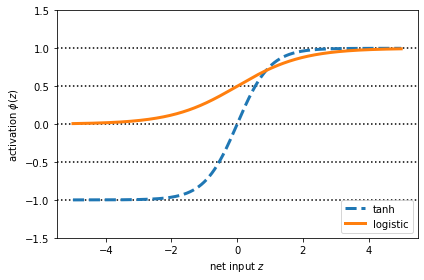

In [106]:
#로지스틱 함수와 하이퍼볼릭 탄젠트 함수 비교
z = np.arange(-5,5,0.005)
log_act = logistic(z)#로지스틱 함수
tanh_act = tanh(z)#하이퍼볼릭 탄젠트

plt.ylim([-1.5,1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1,color = 'black', linestyle = ':')
plt.axhline(0.5,color = 'black', linestyle = ':')
plt.axhline(0,color = 'black', linestyle = ':')
plt.axhline(-0.5,color = 'black', linestyle = ':')
plt.axhline(-1,color = 'black', linestyle = ':')

plt.plot(z, tanh_act,
        linewidth = 3,
        linestyle = '--',
        label = 'tanh')
plt.plot(z, log_act, 
        linewidth = 3,
        label = 'logistic')

plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

In [107]:
#넘파이 tanh 함수
tanh_act = np.tanh(z)

In [108]:
#사이파이 로지스틱 함수
from scipy.special import expit
log_act = expit(z)

### 렐루 활성화 함수(Rectified Linear Unit, ReLU)
$$\phi(z) = max(0,z)$$

- 하이퍼볼릭 탄젠트와 로지스틱 활성화 함수의 그래디언트 소실 문제(vanishing gradient problem)을 개선
- 그래디언트 소실 문제: 그래디언트가 0에 아주 가까워지기 때문에 훈련 과정 동안 가중치가 매우 느리게 학습됨
- 입력 값이 양수면 입력에 대한 렐루의 도함수는 항상 1